# DDQN Agent Demo

### Loading the trained DDQN Agent

In [1]:
from agents.dqn_agent import DQNAgent

"""
Possible agent commands:
  1.             move 1: Move forward
  2. pitch 1 / pitch -1: Look downwards/upwards
  3.   turn 1 / turn -1: Look right/left
  4.           attack 1: Use an attack
"""
COMMANDS_LIST = ['move 1', 'pitch 1', 'pitch -1', 'turn 1', 'turn -1', 'attack 1']
COMMANDS_DICT = {index: obj for index, obj in enumerate(COMMANDS_LIST)}

"""
State Representation: (distance_from_chicken, yaw_error_from_chicken, pitch_error_from_chicken, is_near_wall)
  1.    distance_from_chicken: The agent's distance from the chicken (intervals of 0.25)
  2.   yaw_error_from_chicken: How far off, in degree angles, the agent's looking vector's horizontal component is from the chicken's position (intervals of 10)
  3. pitch_error_from_chicken: How far off, in degree angles, the agent's looking vector's horizontal component is from the chicken's position (intervals of 5)
  4.             is_near_wall: Whether the agent is near a wall or not (1 = is not near wall, -1 = is near wall)
"""
sample_state = (1., 0., 5., 1.)


dqn_agent = DQNAgent(len(sample_state), len(COMMANDS_LIST))
dqn_agent.load("dqn_full_v4_agent.pkl")

Loaded agent with epsilon: 0.14960551470448571 and memory length: 10000


### DDQN - Different states and their optimal actions

In [2]:
state_where_agent_in_range_and_chicken_is_targeted = (1., 0., 5., 1.)
print("State where agent is in range, and the chicken is targeted:")
dqn_agent.act(state_where_agent_in_range_and_chicken_is_targeted)
print()

State where agent is in range, and the chicken is targeted:
optimal action for state tensor([[1., 0., 5., 1.]]): attack 1



In [3]:
state_where_agent_in_range_and_chicken_is_to_the_left = (1., -20., 5., 1.)
print("State where agent is in range, and the chicken is to the left:")
dqn_agent.act(state_where_agent_in_range_and_chicken_is_to_the_left)
print()

State where agent is in range, and the chicken is to the left:
optimal action for state tensor([[  1., -20.,   5.,   1.]]): turn -1



In [4]:
state_where_agent_in_range_and_chicken_is_to_the_right = (1., 20., 5., 1.)
print("State where agent is in range, and the chicken is to the right:")
dqn_agent.act(state_where_agent_in_range_and_chicken_is_to_the_right)
print()

State where agent is in range, and the chicken is to the right:
optimal action for state tensor([[ 1., 20.,  5.,  1.]]): turn 1



In [5]:
state_where_agent_is_far_away_but_chicken_is_targeted = (5., 0., 0., 1.)
print("State where agent is far away, but the chicken is targeted:")
dqn_agent.act(state_where_agent_is_far_away_but_chicken_is_targeted)
print()

State where agent is far away, but the chicken is targeted:
optimal action for state tensor([[5., 0., 0., 1.]]): move 1



### Graphing final performance results: Epsilon vs Cumulative Reward, and Epsilon vs Episode Length

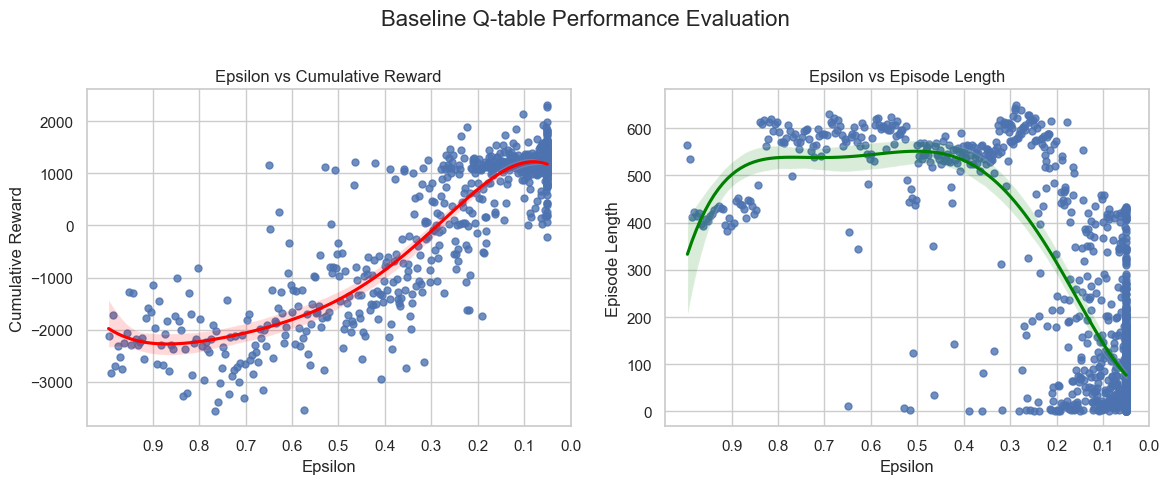

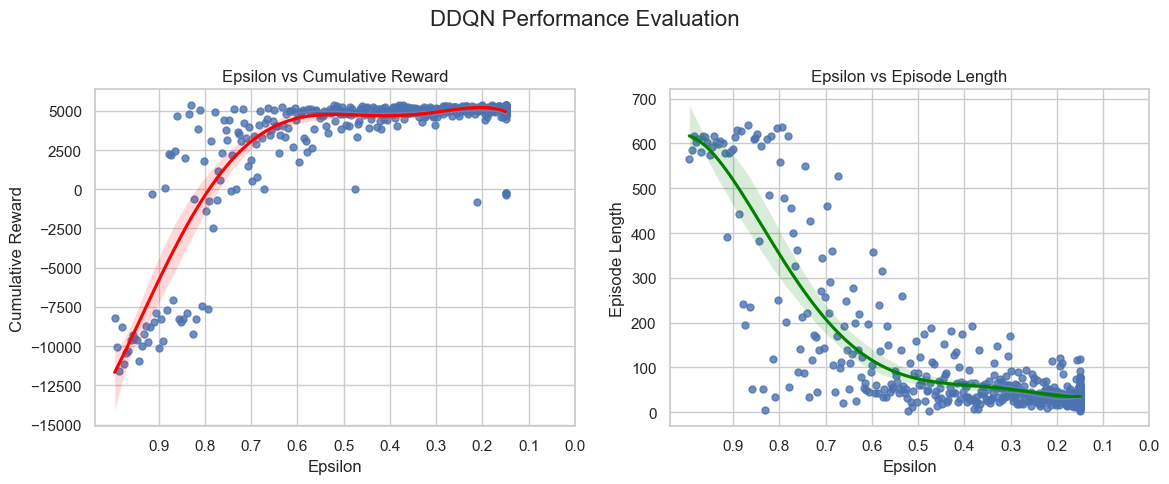

In [6]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

def eval_ddqn_from_csv():
  file_path = 'dqn_full_v4_episode_results.csv'
  df = pd.read_csv(file_path)

  sns.set(style="whitegrid")

  fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

  # Epsilon vs Cumulative Reward (red)
  sns.regplot(x='epsilon', y='cumulative_reward', data=df, order=5, scatter_kws={'s': 25}, line_kws={'color': 'red'}, ax=axes[0])
  axes[0].invert_xaxis()
  axes[0].set_title('Epsilon vs Cumulative Reward')
  axes[0].set_xlabel('Epsilon')
  axes[0].set_ylabel('Cumulative Reward')
  axes[0].grid(True)
  axes[0].set_xticks(np.arange(0, 1, 0.1))

  # Epsilon vs Episode Length (green)
  sns.regplot(x='epsilon', y='episode_length', data=df, order=5, scatter_kws={'s': 25}, line_kws={'color': 'green'}, ax=axes[1])
  axes[1].invert_xaxis()
  axes[1].set_title('Epsilon vs Episode Length')
  axes[1].set_xlabel('Epsilon')
  axes[1].set_ylabel('Episode Length')
  axes[1].grid(True)
  axes[1].set_xticks(np.arange(0, 1, 0.1))

  plt.suptitle('DDQN Performance Evaluation', fontsize=16)
  plt.tight_layout(pad=1.5)
  plt.show()


def eval_baseline_qtable_from_csv():
  df = pd.read_csv('dqn_qtable_baseline_full_simplified_episode_results.csv')

  sns.set(style="whitegrid")

  fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

  # Epsilon vs Cumulative Reward (red)
  sns.regplot(x='epsilon', y='cumulative_reward', data=df, order=5, scatter_kws={'s': 25}, line_kws={'color': 'red'}, ax=axes[0])
  axes[0].invert_xaxis()
  axes[0].set_title('Epsilon vs Cumulative Reward')
  axes[0].set_xlabel('Epsilon')
  axes[0].set_ylabel('Cumulative Reward')
  axes[0].grid(True)
  axes[0].set_xticks(np.arange(0, 1, 0.1))

  # Epsilon vs Episode Length (green)
  sns.regplot(x='epsilon', y='episode_length', data=df, order=5, scatter_kws={'s': 25}, line_kws={'color': 'green'}, ax=axes[1])
  axes[1].invert_xaxis()
  axes[1].set_title('Epsilon vs Episode Length')
  axes[1].set_xlabel('Epsilon')
  axes[1].set_ylabel('Episode Length')
  axes[1].grid(True)
  axes[1].set_xticks(np.arange(0, 1, 0.1))

  plt.suptitle('Baseline Q-table Performance Evaluation', fontsize=16)
  plt.tight_layout(pad=1.5)
  plt.show()


eval_baseline_qtable_from_csv()
eval_ddqn_from_csv()

<hr style="border:2px solid gray">

# Q Table Agent

In [7]:
import numpy as np
import json
import math
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

### Agent class: handles decision making for agent and does all calculations regarding state space and optimal action/ magnitude

In [8]:
class Agent():
    def __init__(self):
        self.value_table = np.zeros((9800, 5))
        self.magnitude_table = np.ones((9800, 5))
        self.nn_input = np.zeros((9800, 4))
        self.prev_state_space = [2, 9, 0, 0]
        self.same_count = 0
        self.prev_row = 0
        self.prev_column = 0
        self.prev_info = {"entities":[{"yaw":270.0,"x":0.5,"y":4.0,"z":0.5,"pitch":30.0,"id":"3637d6bc-9d46-3e7a-8326-bc957d353e98","motionX":0.0,"motionY":-0.0784000015258789,"motionZ":0.0,"life":20.0,"name":"Chicken Deleter"},{"yaw":0.0,"x":3.5,"y":4.0,"z":5.5,"pitch":0.0,"id":"3670ddce-9e97-4542-9278-e7020baaf2b3","motionX":0.0,"motionY":-0.027635999999999997,"motionZ":0.0,"life":4.0,"name":"Chicken"}],"LineOfSight":{"hitType":"block","x":3.30597412875441,"y":4.0,"z":0.5,"type":"grass","prop_snowy":False,"inRange":True,"distance":3.2400448322296143},"DistanceTravelled":0,"TimeAlive":30,"MobsKilled":0,"PlayersKilled":0,"DamageTaken":0,"DamageDealt":0,"Life":20.0,"Score":0,"Food":20,"XP":0,"IsAlive":True,"Air":300,"Name":"Chicken Deleter","XPos":0.5,"YPos":4.0,"ZPos":0.5,"Pitch":30.0,"Yaw":270.0,"WorldTime":5000,"TotalTime":36}

    def action_selection(self, state_space):
        action_dict = {0: "move ", 1: "turn ", 2: "attack ", 3: "pitch ", 4: "jump "}
        index = self.state_space_index(state_space)
        column = np.argmax(self.value_table, axis=1)[index]
        self.prev_column = column
        return action_dict.get(column)

    def magnitude_selection(self, state_space, action):
        column_index = {"move ": 0, "turn ": 1, "attack ": 2, "pitch ": 3, "jump ": 4}
        index = self.state_space_index(state_space)
        column = column_index.get(action)
        magnitude = self.magnitude_table[index][column]
        if magnitude % 1 == 0:
            return int(magnitude)
        else:
            return magnitude


    def state_space_function(self, info):
        try:
            info = json.loads(info)
            self.prev_info = info
        except:
            print(f"exception thrown in state space function")
            info = self.prev_info
        # agent info
        try:
            pitch = round((info.get("Pitch")) / 15)
        except:
            pitch = 0
        agent_x = info.get("XPos")
        agent_z = info.get("ZPos")
        # chicken info
        chicken = info.get("entities")[1]
        chicken_x = chicken.get("x")
        chicken_z = chicken.get("z")
        # hit block info
        line_of_sight = info.get("LineOfSight")
        line_of_sight_x = line_of_sight.get("x")
        line_of_sight_z = line_of_sight.get("z")
        chicken_to_agent = math.sqrt((chicken_x - agent_x) ** 2 + (chicken_z - agent_z) ** 2)
        chicken_to_hit_block = math.sqrt((chicken_x - line_of_sight_x) ** 2 + (chicken_z - line_of_sight_z) ** 2)
        angle = math.atan2((chicken_z - agent_z), (chicken_x - agent_x))
        angle = (math.degrees(angle) + 360) % 360
        yaw = info.get("Yaw")
        offset = 90 - yaw
        angle = 180 - (angle + offset) % 360

        chicken_diff = round(chicken_to_agent - chicken_to_hit_block, 1) * 10
        if chicken_diff < 0:
            chicken_diff = 0
        if chicken_to_agent > 10:
            chicken_to_agent = 10

        if abs(angle) <= 15:
            angle_state = 2
        elif angle < 0:
            angle_state = 1
        else:
            angle_state = 0
        if line_of_sight.get("hitType") == "entity" and line_of_sight.get("inRange"):
            angle_state = 3

        self.prev_state_space = [pitch, round(chicken_to_agent), angle_state, chicken_diff]
        return self.prev_state_space


    def state_space_index(self, state_space):
        index = int(state_space[0] + state_space[1] * 7 + state_space[2] * 70 + state_space[3] * 280)
        self.prev_row = index
        return index

    def reward_adjustment(self, reward):
        if reward < np.argmax(self.value_table, axis=1)[self.prev_row]:
            self.value_table[self.prev_row][self.prev_column] - 5
            self.train_action_nn


### Demonstration of the agent's choice of action and magnitude based on the trained state action values.

In [9]:
agent = Agent()
column_index = {"move ": 0, "turn ": 1, "attack ": 2, "pitch ": 3, "jump ": 4}
action_list = ["move ", "turn ", "attack "]

with open('./magnitude_trained.npy', 'rb') as f:
    agent.magnitude_table = np.load(f)
with open('./value_trained.npy', 'rb') as f:
    agent.value_table = np.load(f)

state_space = [2, 8, 2, 3]
action_type = agent.action_selection(state_space)
magnitude = agent.magnitude_selection(state_space, action_type)
action = action_type + str(magnitude)

print(f"action taken when agent is facing chicken and far away: {action}")

state_space = [2, 5, 1, 3]
action_type = agent.action_selection(state_space)
magnitude = agent.magnitude_selection(state_space, action_type)
action = action_type + str(magnitude)

print(f"action taken when agent is facing left of the chicken: {action}")

state_space = [2, 2, 0, 0]
action_type = agent.action_selection(state_space)
magnitude = agent.magnitude_selection(state_space, action_type)
action = action_type + str(magnitude)

print(f"action taken when agent is facing right of the chicken: {action}")

state_space = [2, 1, 3, 3]
action_type = agent.action_selection(state_space)
magnitude = agent.magnitude_selection(state_space, action_type)
action = action_type + str(magnitude)

print(f"action taken when chicken is in attack box: {action}")

action taken when agent is facing chicken and far away: move 1
action taken when agent is facing left of the chicken: turn 0.2
action taken when agent is facing right of the chicken: turn -0.8
action taken when chicken is in attack box: attack 1


### Creates the graphs to display training curves

/var/folders/l5/sd_w76ls6_nf_6js3ft_8cph0000gn/T/ipykernel_70136/111143972.py:2: RuntimeWarning: overflow encountered in exp
  return a * np.exp(-b * x) + c


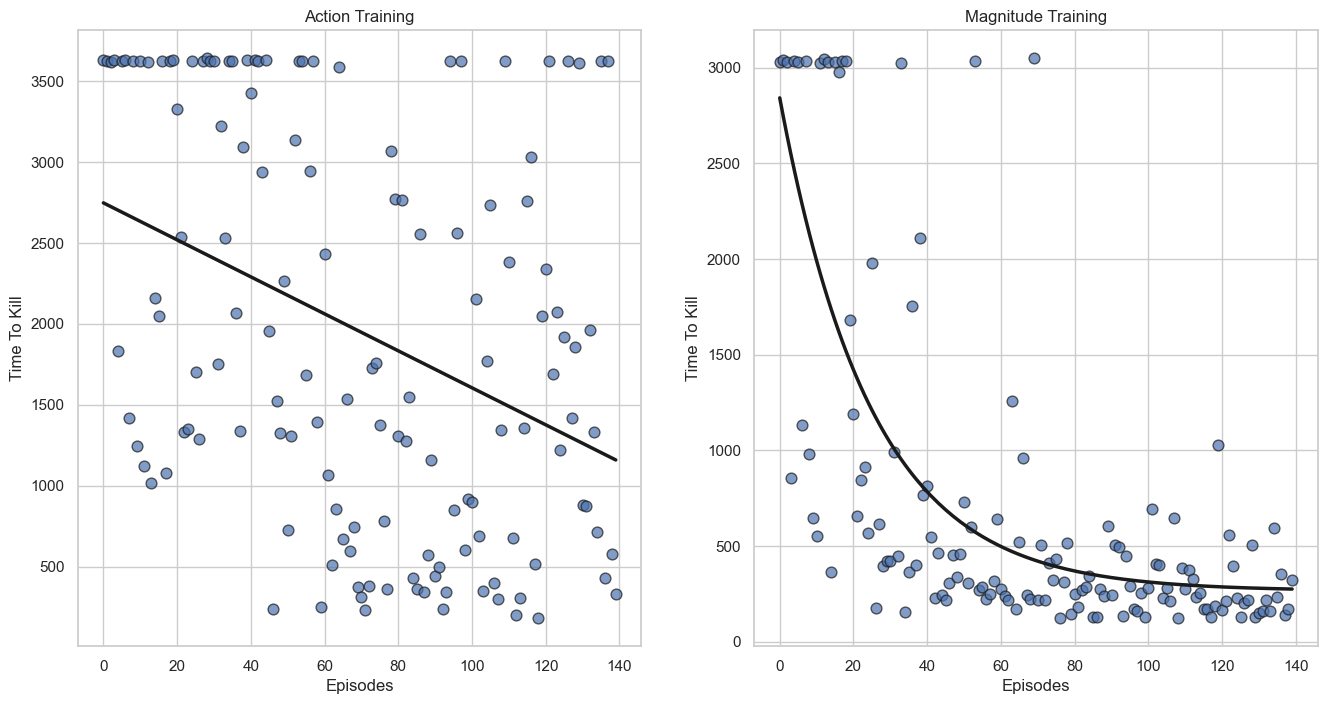

In [10]:
def func(x, a, b, c):
    return a * np.exp(-b * x) + c

x = np.array(range(140))

y0 = np.array([3631, 3622, 3617, 3629, 1835, 3625, 3629, 1420, 3626, 1243, 3620, 1124, 3615, 1016, 2157, 2050, 3625, 1080, 3626, 3628, 3326, 2539, 1335, 1348, 3623, 1701, 1289, 3624, 3640, 3626, 3625, 1754, 3220, 2530, 3624, 3621, 2068, 1338, 3090, 3628, 3423, 3628, 3623, 2935, 3627, 1957, 239, 1522, 1327, 2267, 726, 1310, 3135, 3626, 3626, 1684, 2945, 3624, 1392, 253, 2432, 1069, 510, 857, 3585, 669, 1533, 597, 744, 376, 314, 231, 380, 1730, 1758, 1373, 782, 362, 3069, 2773, 1308, 2763, 1279, 1546, 432, 364, 2554, 346, 571, 1160, 441, 496, 240, 342, 3626, 849, 2563, 3622, 602, 920, 900, 2156, 691, 348, 1768, 2736, 399, 301, 1343, 3623, 2381, 675, 204, 304, 1355, 2756, 3028, 517, 182, 2048, 2338, 3625, 1693, 2072, 1223, 1921, 3626, 1419, 1859, 3613, 884, 874, 1965, 1333, 714, 3620, 428, 3626, 576, 333])
y1 = np.array([3029, 3041, 3031, 856, 3033, 3029, 1132, 3034, 980, 646, 551, 3026, 3043, 3028, 364, 3028, 2979, 3035, 3033, 1680, 1187, 659, 842, 913, 565, 1977, 176, 617, 393, 420, 421, 990, 447, 3025, 157, 364, 1752, 402, 2112, 767, 814, 546, 226, 461, 246, 218, 304, 452, 336, 459, 728, 304, 597, 3034, 272, 283, 224, 248, 317, 640, 277, 236, 218, 1257, 168, 519, 962, 243, 225, 3049, 220, 505, 220, 409, 321, 434, 123, 310, 515, 143, 250, 179, 270, 285, 342, 130, 126, 277, 240, 606, 241, 506, 496, 132, 445, 292, 170, 159, 253, 129, 279, 693, 407, 399, 227, 282, 213, 645, 122, 387, 274, 373, 327, 234, 252, 172, 168, 130, 188, 1029, 167, 214, 558, 393, 227, 131, 204, 220, 505, 126, 147, 162, 216, 159, 592, 234, 354, 137, 170, 322])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (16, 8))
ax1.scatter(x, y0, s=60, alpha=0.7, edgecolors="k")

xseq = np.linspace(0, 140, num=140)

ax1.set_title("Action Training")
a, b = np.polyfit(x, y0, 1)
ax1.plot(x, a*x+b, color="k", lw=2.5)

ax2.set_title("Magnitude Training")
ax2.scatter(x, y1, s=60, alpha=0.7, edgecolors="k")
popt, pcov = curve_fit(func, x, y1)
ax2.plot(x, func(x, *popt), color="k", lw=2.5)


ax1.set(xlabel='Episodes', ylabel='Time To Kill')
ax2.set(xlabel='Episodes', ylabel='Time To Kill')
plt.show()


<hr style="border:2px solid gray">